In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import OrdinalEncoder
from collections import Counter
import math

In [30]:
used_car_df = pd.read_csv('used_cars.csv')

In [31]:
used_car_df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [32]:
used_car_df.dtypes

brand           object
model           object
model_year       int64
milage          object
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price           object
dtype: object

# Data Cleansing

In [33]:
# extract mileage number and price numbers
used_car_df['mileage_num'] = used_car_df['milage'].str.extract(r'([\d,]+)')[0].str.replace(',', '').astype(float)
used_car_df['price_num'] = used_car_df['price'].str.extract(r'([\d,]+)')[0].str.replace(',', '').astype(float)

# drop original mileage and price
used_car_df.drop(columns = ['milage', 'price'], inplace = True)

# Get rid of some anomalies
print(f'before getting rid of anomalies, there are {used_car_df.shape[0]} rows')
used_car_df = used_car_df[(used_car_df['price_num'] < 300000) & (used_car_df['mileage_num'] < 250000) ]
used_car_df = used_car_df[(used_car_df['price_num'] > 0) & (used_car_df['mileage_num'] > 0) ]
print(f'after getting rid of anomalies, there are {used_car_df.shape[0]} rows')

before getting rid of anomalies, there are 4009 rows
after getting rid of anomalies, there are 3966 rows


In [34]:
used_car_df.head()

,brand,model,model_year,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,mileage_num,price_num
0,Ford,Utility Police Interceptor Base,2013,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,51000.0,10300.0
1,Hyundai,Palisade SEL,2021,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,34742.0,38005.0
2,Lexus,RX 350 RX 350,2022,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,22372.0,54598.0
3,INFINITI,Q50 Hybrid Sport,2015,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,88900.0,15500.0
4,Audi,Q3 45 S line Premium Plus,2021,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,9835.0,34999.0


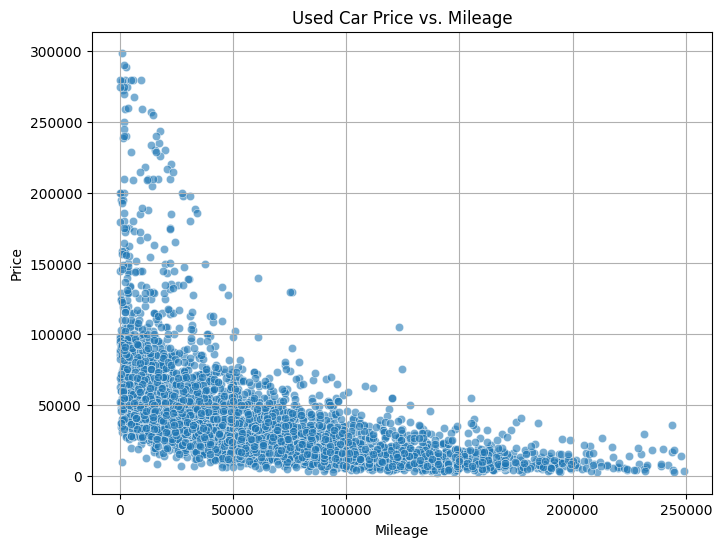

In [35]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=used_car_df, x="mileage_num", y="price_num", alpha=0.6)

# Labels and title
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.title("Used Car Price vs. Mileage")
plt.grid(True)

# Show plot
plt.show()

# Feature Engineering

In [36]:
len(set(used_car_df['model']))

1876

In [37]:
used_car_df['model'].unique()

array(['Utility Police Interceptor Base', 'Palisade SEL', 'RX 350 RX 350',
       ..., 'Martin DB7 Vantage Volante', 'Impala 2LZ', 'Taycan'],
      dtype=object)

In [38]:
for col in ['brand', 'fuel_type', 'ext_col', 'int_col', 'clean_title', 'accident']:

    # Convert 'brand' to categorical type (optional, but good practice)
    used_car_df[col] = used_car_df[col].astype('category')

    # Apply Ordinal Encoding
    encoder = OrdinalEncoder()
    used_car_df[f'{col}_encoded'] = encoder.fit_transform(used_car_df[[col]])
    used_car_df.drop(columns=[col], inplace = True)

In [39]:
used_car_df.head()

,model,model_year,engine,transmission,mileage_num,price_num,brand_encoded,fuel_type_encoded,ext_col_encoded,int_col_encoded,clean_title_encoded,accident_encoded
0,Utility Police Interceptor Base,2013,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,51000.0,10300.0,13.0,1.0,25.0,14.0,0.0,0.0
1,Palisade SEL,2021,3.8L V6 24V GDI DOHC,8-Speed Automatic,34742.0,38005.0,18.0,2.0,179.0,65.0,0.0,0.0
2,RX 350 RX 350,2022,3.5 Liter DOHC,Automatic,22372.0,54598.0,26.0,2.0,34.0,14.0,NaN,1.0
3,Q50 Hybrid Sport,2015,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,88900.0,15500.0,19.0,3.0,25.0,14.0,0.0,1.0
4,Q3 45 S line Premium Plus,2021,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,9835.0,34999.0,3.0,2.0,114.0,14.0,NaN,1.0


In [40]:
# Count word frequency in the 'transmission' column
word_counts = Counter(" ".join(used_car_df['transmission'].astype(str)).lower().split())

# Display the most common words
print(word_counts.most_common(20))  # Adjust the number as needed

for word, count in word_counts.most_common(20):
    print(word)
# Define keywords to extract
keywords = [word for word, count in word_counts.most_common(20)]  # Update based on frequent words

# Create binary columns for each keyword
for keyword in keywords:
    used_car_df[f'transmission_{keyword}'] = used_car_df['transmission'].str.contains(keyword, case=False, na=False).astype(int)

# Drop the original 'transmission' column (if needed)
used_car_df = used_car_df.drop(columns=['transmission'])

[('a/t', 2417), ('6-speed', 694), ('automatic', 688), ('8-speed', 588), ('transmission', 463), ('w/dual', 395), ('shift', 395), ('mode', 395), ('m/t', 353), ('7-speed', 247), ('10-speed', 175), ('5-speed', 151), ('9-speed', 121), ('cvt', 98), ('1-speed', 78), ('4-speed', 74), ('with', 36), ('auto-shift', 34), ('manual', 13), ('automatic,', 12)]
a/t
6-speed
automatic
8-speed
transmission
w/dual
shift
mode
m/t
7-speed
10-speed
5-speed
9-speed
cvt
1-speed
4-speed
with
auto-shift
manual
automatic,


In [41]:
used_car_df[used_car_df['transmission_5-speed'] == 1].head()

,model,model_year,engine,mileage_num,price_num,brand_encoded,fuel_type_encoded,ext_col_encoded,int_col_encoded,clean_title_encoded,...,transmission_10-speed,transmission_5-speed,transmission_9-speed,transmission_cvt,transmission_1-speed,transmission_4-speed,transmission_with,transmission_auto-shift,transmission_manual,"transmission_automatic,"
42,Sprinter 2500,2007,3.0L V6 Cylinder Engine Diesel Fuel,189719.0,14000.0,10.0,0.0,297.0,65.0,0.0,...,0,1,0,0,0,0,0,0,0,0
70,300C SRT8,2006,425.0HP 6.1L 8 Cylinder Engine Gasoline Fuel,43000.0,19995.0,9.0,2.0,257.0,14.0,0.0,...,0,1,0,0,0,0,0,0,0,0
79,ES 330 Base,2005,225.0HP 3.3L V6 Cylinder Engine Gasoline Fuel,41059.0,11100.0,26.0,2.0,297.0,10.0,0.0,...,0,1,0,0,0,0,0,0,0,0
156,4Runner SR5,2022,4.0L V6 24V MPFI DOHC,28377.0,36999.0,52.0,2.0,257.0,65.0,NaN,...,0,1,0,0,0,0,0,0,0,0
188,Lancer Evolution GSR,2012,291.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,33000.0,34999.0,37.0,2.0,25.0,14.0,0.0,...,0,1,0,0,0,0,0,0,0,0


In [42]:
# Count word frequency in the 'transmission' column
word_counts = Counter(" ".join(used_car_df['engine'].astype(str)).lower().split())

# Display the most common words
print(word_counts.most_common(30))  # Adjust the number as needed
# Define keywords to extract
keywords = [word for word, count in word_counts.most_common(20)]  # Update based on frequent words

# Create binary columns for each keyword
for keyword in keywords:
    used_car_df[f'engine_{keyword}'] = used_car_df['engine'].str.contains(keyword, case=False, na=False).astype(int)

# Drop the original 'transmission' column (if needed)
used_car_df = used_car_df.drop(columns=['engine'])

[('engine', 3048), ('cylinder', 3040), ('fuel', 3021), ('gasoline', 2657), ('v6', 1056), ('8', 994), ('4', 737), ('2.0l', 471), ('3.0l', 431), ('dohc', 424), ('electric', 389), ('6', 338), ('3.5l', 333), ('gdi', 303), ('turbo', 289), ('straight', 242), ('3.6l', 235), ('16v', 233), ('24v', 184), ('4.0l', 179), ('2.5l', 174), ('6.2l', 172), ('hybrid', 161), ('i4', 158), ('liter', 157), ('motor', 151), ('system', 146), ('v8', 134), ('flex', 128), ('capability', 128)]


In [43]:
used_car_df.head()

,model,model_year,mileage_num,price_num,brand_encoded,fuel_type_encoded,ext_col_encoded,int_col_encoded,clean_title_encoded,accident_encoded,...,engine_electric,engine_6,engine_3.5l,engine_gdi,engine_turbo,engine_straight,engine_3.6l,engine_16v,engine_24v,engine_4.0l
0,Utility Police Interceptor Base,2013,51000.0,10300.0,13.0,1.0,25.0,14.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
1,Palisade SEL,2021,34742.0,38005.0,18.0,2.0,179.0,65.0,0.0,0.0,...,0,1,0,1,0,0,0,0,1,0
2,RX 350 RX 350,2022,22372.0,54598.0,26.0,2.0,34.0,14.0,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
3,Q50 Hybrid Sport,2015,88900.0,15500.0,19.0,3.0,25.0,14.0,0.0,1.0,...,1,1,1,0,0,0,0,0,0,0
4,Q3 45 S line Premium Plus,2021,9835.0,34999.0,3.0,2.0,114.0,14.0,NaN,1.0,...,0,1,0,1,1,0,0,1,0,0


In [44]:
# Count word frequency in the 'transmission' column
word_counts = Counter(" ".join(used_car_df['model'].astype(str)).lower().split())

# Display the most common words
print(word_counts.most_common(10))  # Adjust the number as needed

# Define keywords to extract
keywords = [word for word, count in word_counts.most_common(10)]  # Update based on frequent words

# Create binary columns for each keyword
for keyword in keywords:
    used_car_df[f'model_{keyword}'] = used_car_df['model'].str.contains(keyword, case=False, na=False).astype(int)

# Drop the original 'transmission' column (if needed)
used_car_df = used_car_df.drop(columns=['model'])

[('base', 630), ('premium', 248), ('s', 246), ('rover', 227), ('sport', 190), ('i', 144), ('range', 141), ('1500', 139), ('4matic', 128), ('limited', 123)]


In [45]:
used_car_df.head()

,model_year,mileage_num,price_num,brand_encoded,fuel_type_encoded,ext_col_encoded,int_col_encoded,clean_title_encoded,accident_encoded,transmission_a/t,...,model_base,model_premium,model_s,model_rover,model_sport,model_i,model_range,model_1500,model_4matic,model_limited
0,2013,51000.0,10300.0,13.0,1.0,25.0,14.0,0.0,0.0,1,...,1,0,1,0,0,1,0,0,0,0
1,2021,34742.0,38005.0,18.0,2.0,179.0,65.0,0.0,0.0,0,...,0,0,1,0,0,1,0,0,0,0
2,2022,22372.0,54598.0,26.0,2.0,34.0,14.0,NaN,1.0,0,...,0,0,0,0,0,0,0,0,0,0
3,2015,88900.0,15500.0,19.0,3.0,25.0,14.0,0.0,1.0,1,...,0,0,1,0,1,1,0,0,0,0
4,2021,9835.0,34999.0,3.0,2.0,114.0,14.0,NaN,1.0,0,...,0,1,1,0,0,1,0,0,0,0


In [46]:
used_car_df.shape

(3966, 59)

# Train Test Split

In [47]:
set(used_car_df.columns)

{'accident_encoded',
 'brand_encoded',
 'clean_title_encoded',
 'engine_16v',
 'engine_2.0l',
 'engine_24v',
 'engine_3.0l',
 'engine_3.5l',
 'engine_3.6l',
 'engine_4',
 'engine_4.0l',
 'engine_6',
 'engine_8',
 'engine_cylinder',
 'engine_dohc',
 'engine_electric',
 'engine_engine',
 'engine_fuel',
 'engine_gasoline',
 'engine_gdi',
 'engine_straight',
 'engine_turbo',
 'engine_v6',
 'ext_col_encoded',
 'fuel_type_encoded',
 'int_col_encoded',
 'mileage_num',
 'model_1500',
 'model_4matic',
 'model_base',
 'model_i',
 'model_limited',
 'model_premium',
 'model_range',
 'model_rover',
 'model_s',
 'model_sport',
 'model_year',
 'price_num',
 'transmission_1-speed',
 'transmission_10-speed',
 'transmission_4-speed',
 'transmission_5-speed',
 'transmission_6-speed',
 'transmission_7-speed',
 'transmission_8-speed',
 'transmission_9-speed',
 'transmission_a/t',
 'transmission_auto-shift',
 'transmission_automatic',
 'transmission_automatic,',
 'transmission_cvt',
 'transmission_m/t',
 't

In [ ]:
# Define target variable
y = used_car_df['price_num']

# Define feature columns
feature_cols = [
    'accident_encoded', 'brand_encoded', 'clean_title_encoded',
    'engine_16v', 'engine_2.0l', 'engine_24v', 'engine_3.0l', 'engine_3.5l',
    'engine_3.6l', 'engine_4', 'engine_4.0l', 'engine_6', 'engine_8',
    'engine_cylinder', 'engine_dohc', 'engine_electric', 'engine_engine',
    'engine_fuel', 'engine_gasoline', 'engine_gdi', 'engine_straight',
    'engine_turbo', 'engine_v6', 'ext_col_encoded', 'fuel_type_encoded',
    'int_col_encoded', 'mileage_num', 'model_1500', 'model_4matic',
    'model_base', 'model_i', 'model_limited', 'model_premium', 'model_range',
    'model_rover', 'model_s', 'model_sport', 'model_year',
    'transmission_1-speed', 'transmission_10-speed', 'transmission_4-speed',
    'transmission_5-speed', 'transmission_6-speed', 'transmission_7-speed',
    'transmission_8-speed', 'transmission_9-speed', 'transmission_a/t',
    'transmission_auto-shift', 'transmission_automatic', 'transmission_automatic,',
    'transmission_cvt', 'transmission_m/t', 'transmission_manual',
    'transmission_mode', 'transmission_shift', 'transmission_transmission',
    'transmission_w/dual', 'transmission_with'
]

# feature_cols = ['mileage_num', 
#                 'accident_encoded', 'brand_encoded', 'clean_title_encoded','ext_col_encoded', 'fuel_type_encoded','int_col_encoded'
#             # 'accident_encoded', 'brand_encoded', 'clean_title_encoded',
#     # 'engine_16v', 'engine_2.0l', 'engine_24v', 'engine_3.0l', 'engine_3.5l',
#     # 'engine_3.6l', 'engine_4', 'engine_4.0l', 'engine_6', 'engine_8',
#     # 'engine_cylinder', 'engine_dohc', 'engine_electric', 'engine_engine',
#     # 'engine_fuel', 'engine_gasoline', 'engine_gdi', 'engine_straight',
#     # 'engine_turbo', 'engine_v6', 'ext_col_encoded', 'fuel_type_encoded',
#     # 'int_col_encoded', 'mileage_num', 'model_1500', 'model_4matic',
#     # 'model_base', 'model_i', 'model_limited', 'model_premium', 'model_range',
#     # 'model_rover', 'model_s', 'model_sport', 'model_year',
#     # 'transmission_1-speed', 'transmission_10-speed', 'transmission_4-speed',
#     # 'transmission_5-speed', 'transmission_6-speed', 'transmission_7-speed',
#     # 'transmission_8-speed', 'transmission_9-speed', 'transmission_a/t',
#     # 'transmission_auto-shift', 'transmission_automatic', 'transmission_automatic,',
#     # 'transmission_cvt', 'transmission_m/t', 'transmission_manual',
#     # 'transmission_mode', 'transmission_shift', 'transmission_transmission',
#     # 'transmission_w/dual', 'transmission_with'
# ]

# Using mileage_num
# LR: 80.06%
# KNN: 58.56%
# Simple Tree: 60.74%
# RF: 59.39%
# GB: 58.80%
# XGB: 59.46%

# Using mileague_num and all encoded features:
# LR: 79.04%
# KNN: 58.58%
# Simple Tree: 55.64%
# RF: 52.51%
# GB: 47.98%
# XGB: 44.98%

# Use all features (mileague, encoded features and extracted features)
# LR: 61.91%
# KNN: 58.57%
# Simple Tree: 47.48%
# RF: 39.81%
# GB: 37.98%
# XGB: 34.94%
# XGB with grid search: 31.97%


X = used_car_df[feature_cols]

# Split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3172, 58)
X_test shape: (794, 58)
y_train shape: (3172,)
y_test shape: (794,)


In [65]:
# deal with NA values
X_train = X_train.fillna(X_train.mean())  # Replace NaN with column mean
X_test = X_test.fillna(X_train.mean())    # Use training mean to prevent data leakage

# Try Linear Regression model

Mean Squared Error (MSE): 698220526.61
Mean Absolute Percentage Error (MAPE): 61.91%


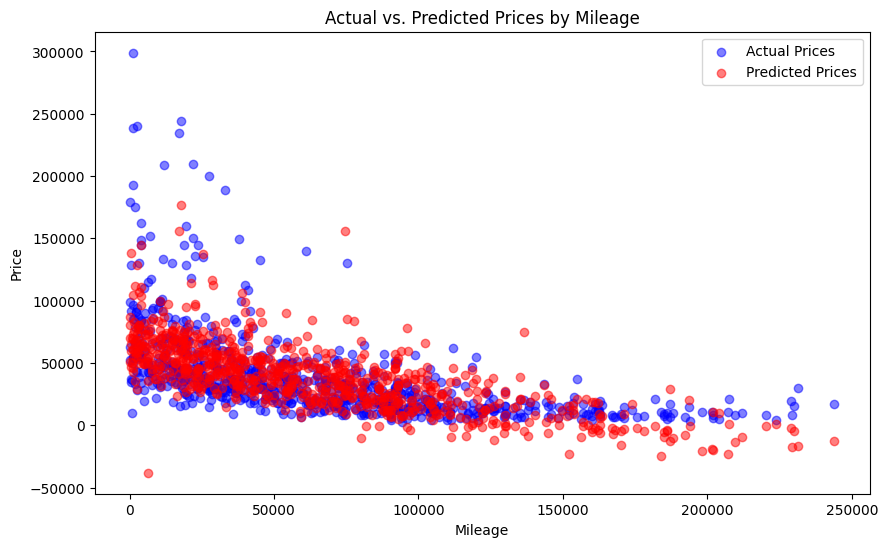

Top 10 Important Features:
                      Feature    Importance
53          transmission_mode  60983.607642
52        transmission_manual  57812.754450
54         transmission_shift  44455.261342
51           transmission_m/t  43326.494102
55  transmission_transmission  40213.047020
46           transmission_a/t  39592.426781
3                  engine_16v  38982.777658
10                engine_4.0l  33257.003087
17                engine_fuel  26810.115888
47    transmission_auto-shift  23882.992733


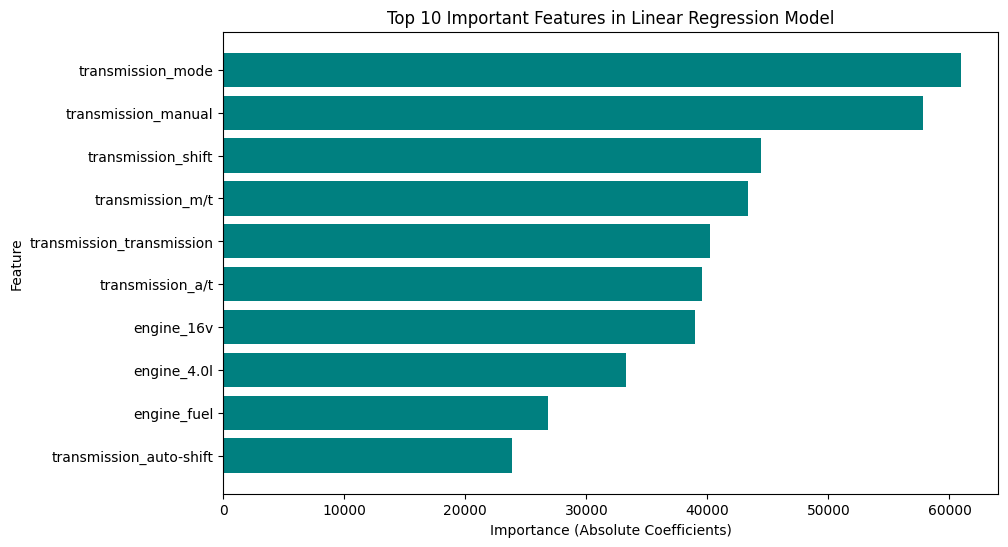

In [66]:
# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

plt.figure(figsize=(10, 6))

# Scatter plot for actual prices
plt.scatter(X_test['mileage_num'], y_test, color='blue', label="Actual Prices", alpha=0.5)

# Scatter plot for predicted prices
plt.scatter(X_test['mileage_num'], y_pred, color='red', label="Predicted Prices", alpha=0.5)

# Labels and title
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Prices by Mileage")
plt.legend()
plt.show()

# Get feature importance (absolute coefficient values)
feature_importance = np.abs(lr_model.coef_)

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort by importance and get top 10
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Print top 10 features
print("Top 10 Important Features:")
print(top_10_features)

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='teal')
plt.xlabel("Importance (Absolute Coefficients)")
plt.ylabel("Feature")
plt.title("Top 10 Important Features in Linear Regression Model")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# Try KNN model

Mean Squared Error (MSE): 868740284.36
Mean Absolute Percentage Error (MAPE): 58.57%


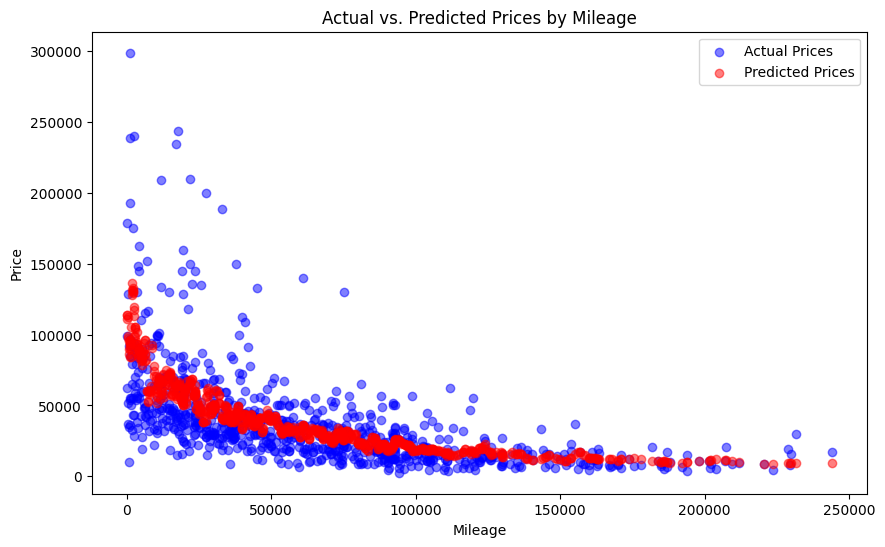

Top 10 Important Features (based on correlation with price):
mileage_num                0.537535
model_year                 0.442554
transmission_auto-shift    0.272533
transmission_with          0.268951
engine_engine              0.218867
accident_encoded           0.218195
engine_cylinder            0.217513
engine_fuel                0.212145
engine_4.0l                0.202376
transmission_automatic     0.199823
dtype: float64


/home/codespace/.python/current/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/codespace/.python/current/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


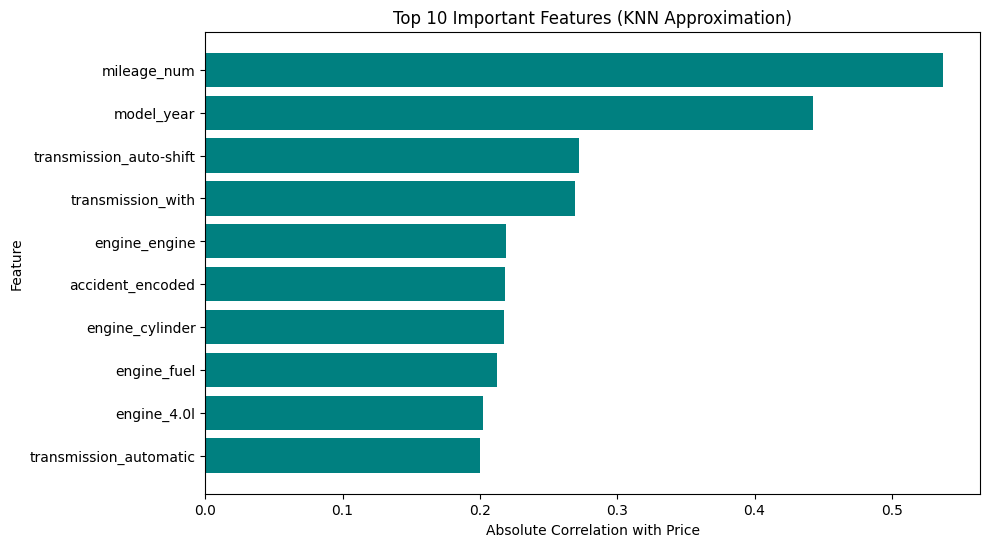

In [67]:
# Initialize KNN Regressor with 25 neighbors
knn_model = KNeighborsRegressor(n_neighbors=25)

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

plt.figure(figsize=(10, 6))

# Scatter plot for actual prices
plt.scatter(X_test['mileage_num'], y_test, color='blue', label="Actual Prices", alpha=0.5)

# Scatter plot for predicted prices
plt.scatter(X_test['mileage_num'], y_pred, color='red', label="Predicted Prices", alpha=0.5)

# Labels and title
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Prices by Mileage")
plt.legend()
plt.show()

# Compute correlation between features and target
feature_correlation = X_train.corrwith(y_train).abs()

# Sort by importance and get top 10
top_10_features = feature_correlation.sort_values(ascending=False).head(10)

# Print top 10 features
print("Top 10 Important Features (based on correlation with price):")
print(top_10_features)

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features.index, top_10_features.values, color='teal')
plt.xlabel("Absolute Correlation with Price")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (KNN Approximation)")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# Try a Regression Tree

Mean Squared Error (MSE): 716277499.66
Mean Absolute Percentage Error (MAPE): 47.48%


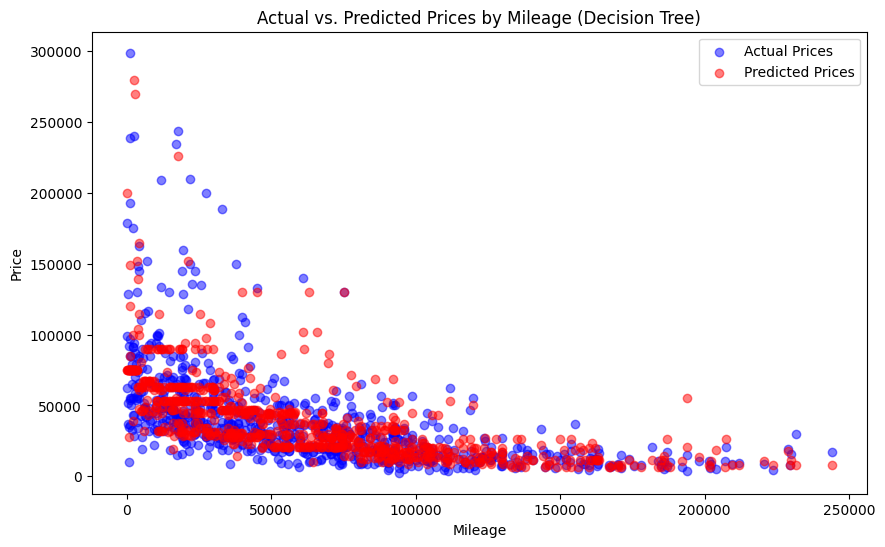

Top 10 Important Features:
              Feature  Importance
26        mileage_num    0.497232
10        engine_4.0l    0.085926
1       brand_encoded    0.057887
37         model_year    0.043113
57  transmission_with    0.033644
11           engine_6    0.028813
25    int_col_encoded    0.027060
29         model_base    0.027019
3          engine_16v    0.019653
46   transmission_a/t    0.018702


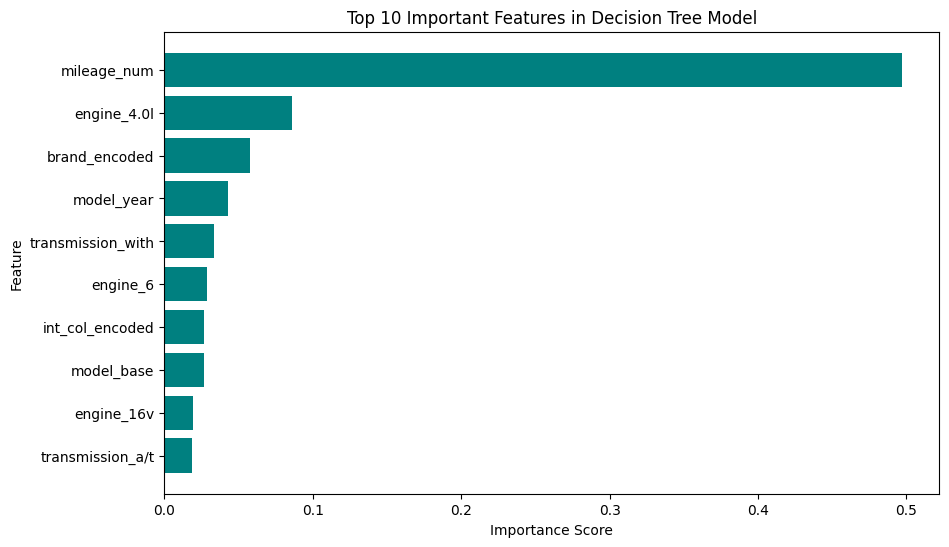

In [68]:
# Initialize Decision Tree Regressor
tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)  # Adjust max_depth if needed

# Train the model
tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = tree_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

plt.figure(figsize=(10, 6))

# Scatter plot for actual prices
plt.scatter(X_test['mileage_num'], y_test, color='blue', label="Actual Prices", alpha=0.5)

# Scatter plot for predicted prices
plt.scatter(X_test['mileage_num'], y_pred, color='red', label="Predicted Prices", alpha=0.5)

# Labels and title
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Prices by Mileage (Decision Tree)")
plt.legend()
plt.show()

# Get feature importance
feature_importance = tree_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort by importance and get top 10
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Print top 10 features
print("Top 10 Important Features:")
print(top_10_features)

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='teal')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features in Decision Tree Model")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# Try Random Forest

Mean Squared Error (MSE): 453982145.57
Mean Absolute Percentage Error (MAPE): 39.81%


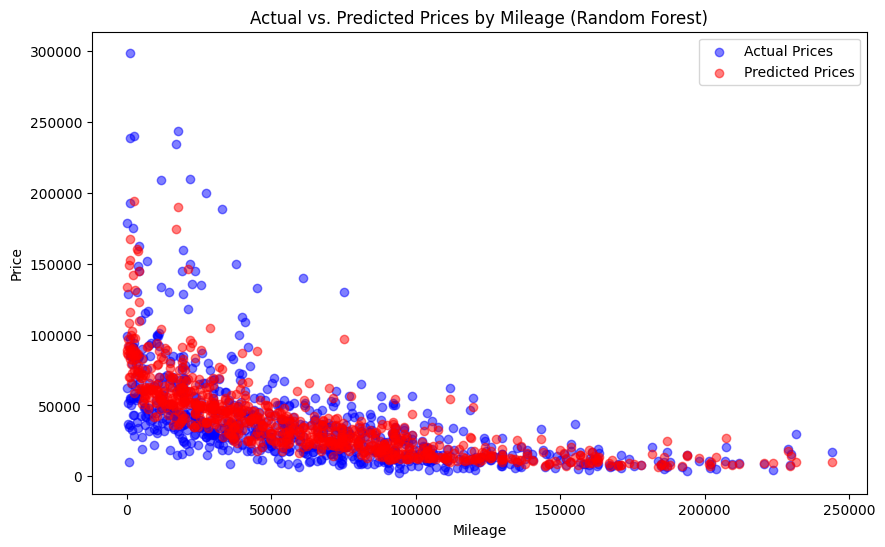

Top 10 Important Features:
                    Feature  Importance
26              mileage_num    0.482115
10              engine_4.0l    0.071504
37               model_year    0.070963
1             brand_encoded    0.060243
47  transmission_auto-shift    0.033701
23          ext_col_encoded    0.028259
25          int_col_encoded    0.026324
29               model_base    0.015759
14              engine_dohc    0.013620
12                 engine_8    0.013101


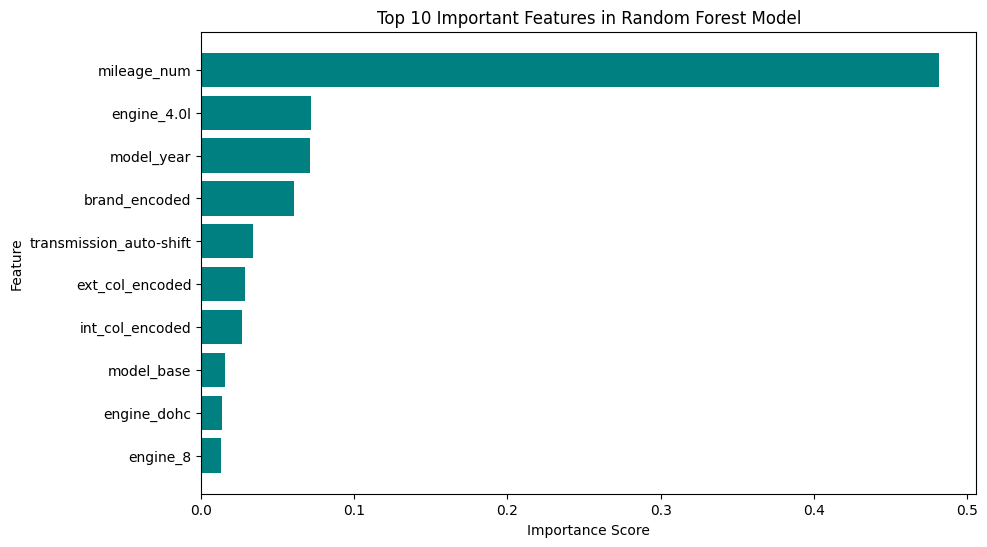

In [69]:
# Initialize Random Forest Regressor with 100 trees
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

plt.figure(figsize=(10, 6))

# Scatter plot for actual prices
plt.scatter(X_test['mileage_num'], y_test, color='blue', label="Actual Prices", alpha=0.5)

# Scatter plot for predicted prices
plt.scatter(X_test['mileage_num'], y_pred, color='red', label="Predicted Prices", alpha=0.5)

# Labels and title
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Prices by Mileage (Random Forest)")
plt.legend()
plt.show()

# Get feature importance
feature_importance = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort by importance and get top 10
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Print top 10 features
print("Top 10 Important Features:")
print(top_10_features)

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='teal')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features in Random Forest Model")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# Try Gradient Boost

Mean Squared Error (MSE): 418801743.32
Mean Absolute Percentage Error (MAPE): 37.98%


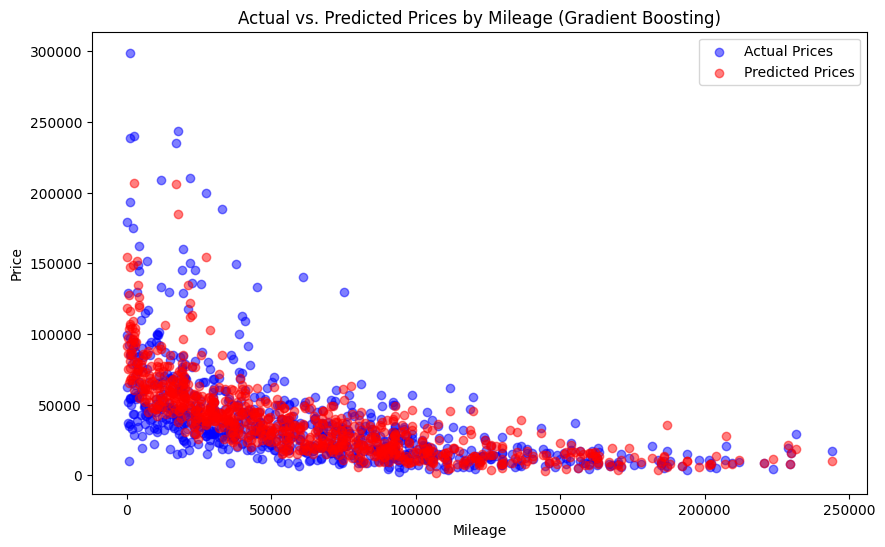

Top 10 Important Features:
                    Feature  Importance
26              mileage_num    0.525557
1             brand_encoded    0.105479
10              engine_4.0l    0.073880
37               model_year    0.054375
47  transmission_auto-shift    0.026271
57        transmission_with    0.019861
14              engine_dohc    0.019470
25          int_col_encoded    0.018934
3                engine_16v    0.015066
4               engine_2.0l    0.013690


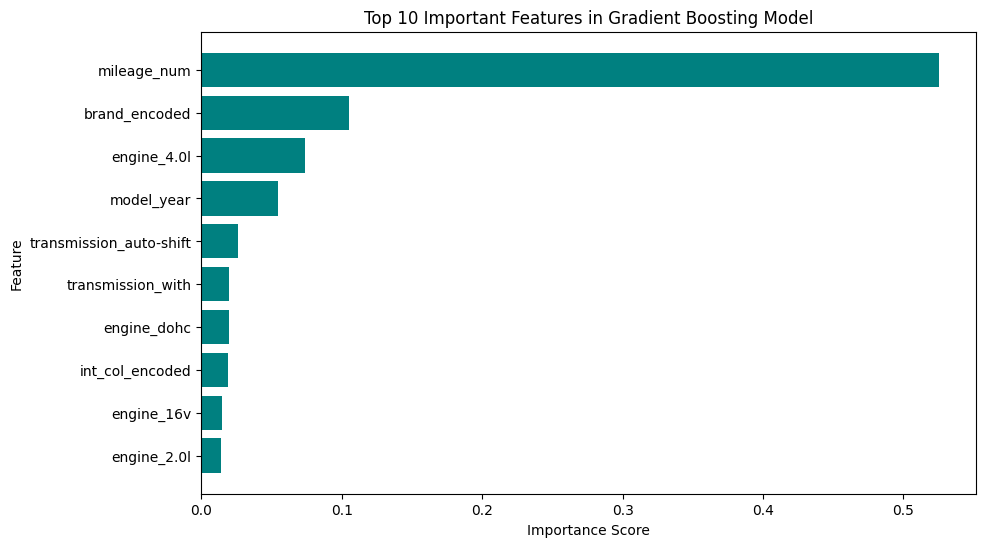

In [70]:
# Initialize Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

plt.figure(figsize=(10, 6))

# Scatter plot for actual prices
plt.scatter(X_test['mileage_num'], y_test, color='blue', label="Actual Prices", alpha=0.5)

# Scatter plot for predicted prices
plt.scatter(X_test['mileage_num'], y_pred, color='red', label="Predicted Prices", alpha=0.5)

# Labels and title
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Prices by Mileage (Gradient Boosting)")
plt.legend()
plt.show()

# Get feature importance
feature_importance = gb_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort by importance and get top 10
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Print top 10 features
print("Top 10 Important Features:")
print(top_10_features)

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='teal')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features in Gradient Boosting Model")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# Try XGboost

Mean Squared Error (MSE): 346210904.97
Mean Absolute Percentage Error (MAPE): 34.94%


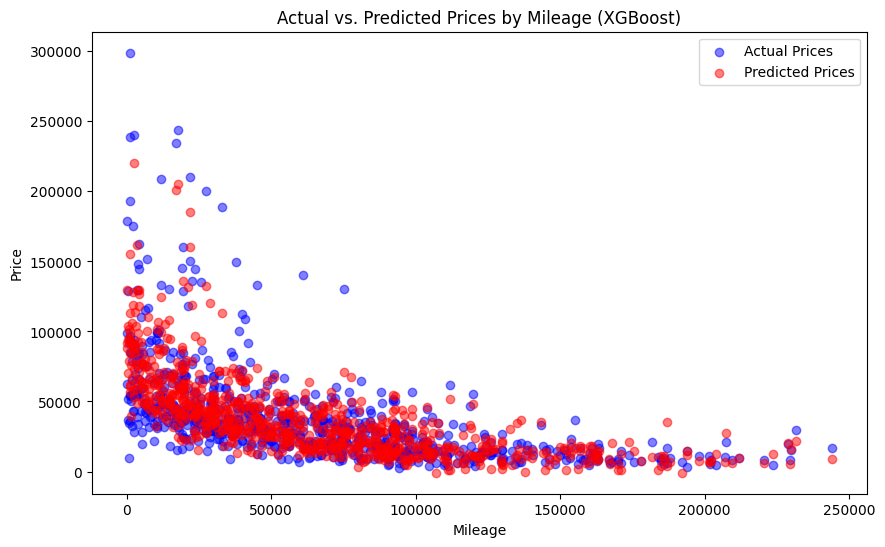

Top 10 Important Features:
                    Feature  Importance
47  transmission_auto-shift    0.148857
10              engine_4.0l    0.087311
46         transmission_a/t    0.076271
14              engine_dohc    0.066861
26              mileage_num    0.060645
57        transmission_with    0.057858
3                engine_16v    0.041687
52      transmission_manual    0.032764
29               model_base    0.024125
4               engine_2.0l    0.023304


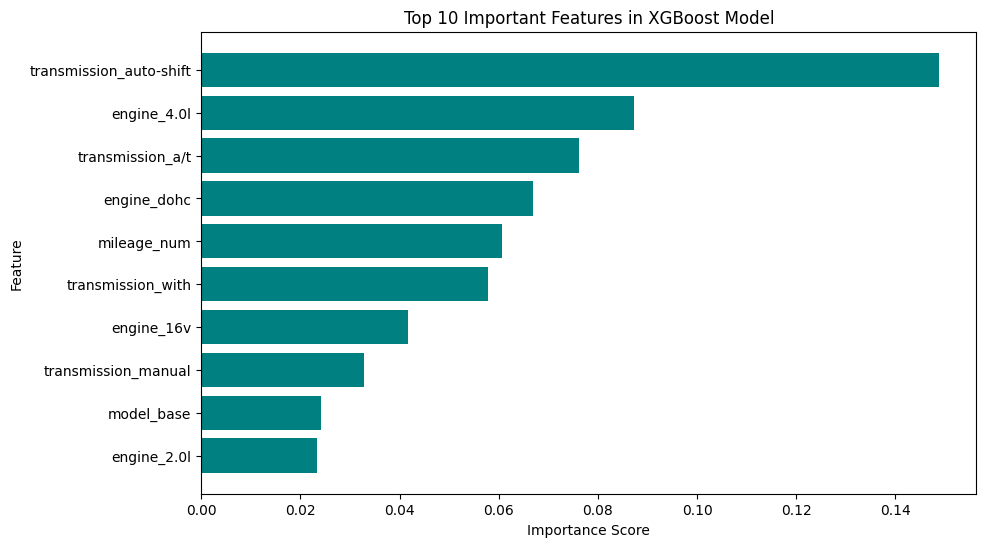

In [71]:
# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=3, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

plt.figure(figsize=(10, 6))

# Scatter plot for actual prices
plt.scatter(X_test['mileage_num'], y_test, color='blue', label="Actual Prices", alpha=0.5)

# Scatter plot for predicted prices
plt.scatter(X_test['mileage_num'], y_pred, color='red', label="Predicted Prices", alpha=0.5)

# Labels and title
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Prices by Mileage (XGBoost)")
plt.legend()
plt.show()

# Get feature importance
feature_importance = xgb_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort by importance and get top 10
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Print top 10 features
print("Top 10 Important Features:")
print(top_10_features)

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='teal')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features in XGBoost Model")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# Try XGBOOST Grid Search

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best hyperparameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 1.0}
Mean Squared Error (MSE): 291280979.09
Mean Absolute Percentage Error (MAPE): 31.97%


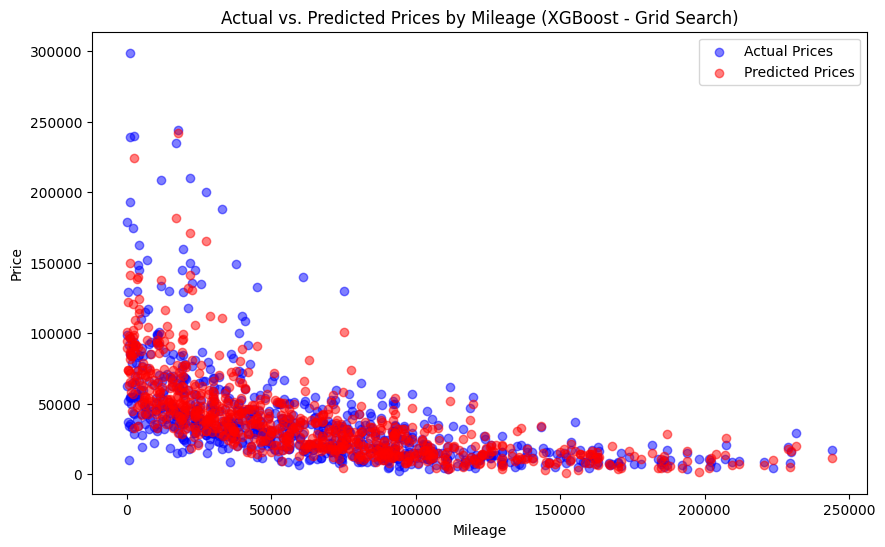

Top 10 Important Features:
                    Feature  Importance
57        transmission_with    0.136779
10              engine_4.0l    0.078944
14              engine_dohc    0.059094
47  transmission_auto-shift    0.054767
26              mileage_num    0.049834
37               model_year    0.028413
16            engine_engine    0.027514
34              model_rover    0.026621
43     transmission_7-speed    0.026232
54       transmission_shift    0.026174


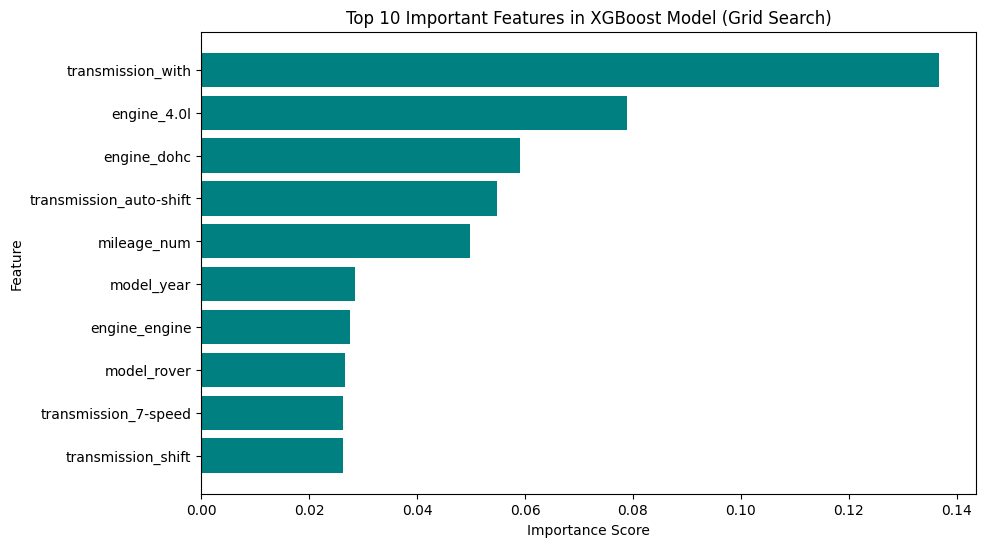

In [72]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of boosting rounds
    'max_depth': [3, 5, 7],  # Maximum depth of the tree
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'subsample': [0.8, 1.0],  # Fraction of samples used for fitting
    'colsample_bytree': [0.8, 1.0]  # Fraction of features used for fitting
}

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_xgb_model = grid_search.best_estimator_

# Output best parameters
print("Best hyperparameters found: ", grid_search.best_params_)

# Use the best model to predict on the test set
y_pred = best_xgb_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

plt.figure(figsize=(10, 6))

# Scatter plot for actual prices
plt.scatter(X_test['mileage_num'], y_test, color='blue', label="Actual Prices", alpha=0.5)

# Scatter plot for predicted prices
plt.scatter(X_test['mileage_num'], y_pred, color='red', label="Predicted Prices", alpha=0.5)

# Labels and title
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Prices by Mileage (XGBoost - Grid Search)")
plt.legend()
plt.show()

# Get feature importance from the best model
feature_importance = best_xgb_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort by importance and get top 10
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Print top 10 features
print("Top 10 Important Features:")
print(top_10_features)

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='teal')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features in XGBoost Model (Grid Search)")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

## Mean Absolute Percentage Error (% error)
### - Linear Regression: 61.91%
### - KNN: 58.57%
### - Decision Tree Regressor: 47.48%
### - Random Forest: 39.81%
### - Gradient Boost: 37.98%
### - XGBOOST: 34.94%
### - XGBOOST Grid Search: 31.97%